In [1]:
# -------------------------------------------------
# generate .txt files of time series data to
# feed into scepter climatology
# -------------------------------------------------

In [68]:
import os

import cftime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# ---
# set ensemble
LE_ens_tag = "1231-001"  # ensemble member start year and member id

# ---
# set time duration constraints
lterm_mean = False
# set start and end date
start_year = 2020  # set large bounds for easy way to get full data (e.g., 0-4000)
end_year = 2100
n_yr_repeatmean = 100  # only used if lterm_mean = True

# ---
datdir = (
    "/home/tykukla/aglime-swap-cdr/cesm2/data/postprocessed"  # location of cesm2le data
)
save_path = "/home/tykukla/aglime-swap-cdr/scepter/clim-inputs"  # location for climatology files

In [69]:
# --- information about vars


class Var:
    def __init__(self, varname, filename, dataset_loc, colname_var, colname_time):
        self.varname = varname
        self.filename = filename
        self.dataset_loc = dataset_loc
        self.colname_var = colname_var
        self.colname_time = colname_time

In [70]:
# --- function to write output file


def write_output(outdir, var, arrvar, arrtime):
    file_path = os.path.join(outdir, var.filename)
    # open the file in write mode
    with open(file_path, "w") as file:
        # write header
        h1 = "# " + var.colname_time
        h2 = var.colname_var
        file.write(f"{h1}\t{h2}\n")
        # write each pair of values from the arrays to the file
        for value1, value2 in zip(arrtime, arrvar):
            formatted_value1 = f"{value1:.7f}"
            formatted_value2 = f"{value2:.7f}"
            file.write(
                f"{formatted_value1}\t{formatted_value2}\n"
            )  # Separate values by tab and end line with newline character

In [71]:
# --- read in datasets
fn_atm = "cesm2le_" + LE_ens_tag + "_atmosvars.zarr"
fn_lnd = "cesm2le_" + LE_ens_tag + "_landvars.zarr"
spin_in_path = "/home/tykukla/aglime-swap-cdr/scepter/batch-inputs"
spin_inputs = "spinup-inputs.csv"
# read in
dsatm = xr.open_zarr(os.path.join(datdir, fn_atm))
dslnd = xr.open_zarr(os.path.join(datdir, fn_lnd))
df = pd.read_csv(os.path.join(spin_in_path, spin_inputs))

In [72]:
# --- extract and save time series
# set start and end dates
start_date = cftime.datetime(start_year, 1, 1, has_year_zero=True, calendar="noleap")
end_date = cftime.datetime(end_year, 12, 31, has_year_zero=True, calendar="noleap")
# ---

# get subdirs
save_subdir = "cesm2le_monthly_ens-" + LE_ens_tag
# loop through sites
for idx in range(len(df)):
    # site name
    thissite = df.loc[idx, "site"]
    # get the nearest lat and lon
    slat = df.loc[idx, "lat"]
    slon = df.loc[idx, "lon"]

    # write input files
    with open("inputvar_details.txt") as file:
        # skip the first line
        next(file)
        # loop through each line in the file
        for line in file:
            # create var object
            thisvar = Var(*line.strip().split(","))
            # set the temporary dataset
            if thisvar.dataset_loc == "atm":
                tmpds = dsatm.copy()
            else:
                tmpds = dslnd.copy()
            # get timeslice
            tmp_slice = tmpds.sel(time=slice(start_date, end_date))
            # pull out data
            if lterm_mean:
                tmp_slice2 = tmp_slice.sel(lat=slat, lon=slon, method="nearest")
                tmp_1yr = (
                    tmp_slice2[thisvar.varname]
                    .groupby("time.month")
                    .mean(dim="time")
                    .values
                )
                tmp = np.concatenate((tmp_1yr,) * n_yr_repeatmean, axis=0)
                nsteps = len(tmp)
                yrmin, yrmax = float(0), float(n_yr_repeatmean)
            if not lterm_mean:
                # clim data
                tmp = (
                    tmp_slice[thisvar.varname]
                    .sel(lat=slat, lon=slon, method="nearest")
                    .values
                )
                # yrs
                nsteps = len(tmpds["time"])
                yrmin, yrmax = float(0), float(nsteps / 12)
            # set yr array and save
            yrs = np.linspace(yrmin, yrmax, nsteps)
            # name the output directory
            if lterm_mean:
                yr_string = (
                    str(start_year)
                    + "-"
                    + str(end_year)
                    + "mean_x"
                    + str(n_yr_repeatmean)
                    + "yr"
                )
                savehere = os.path.join(save_path, save_subdir, yr_string, thissite)
            else:
                yr_string = str(start_year) + "-" + str(end_year)
                savehere = os.path.join(save_path, save_subdir, yr_string, thissite)
            # write the output file
            if not os.path.exists(savehere):
                os.makedirs(savehere)
            write_output(savehere, thisvar, tmp, yrs)

In [49]:
# ---------------------------------------------------------------------------------------- #
#
# ---------------------------------------------------------------------------------------- #

In [50]:
# --- read in .txt files
# get file names
f1, f2, f3 = "q_temp.in", "T_temp.in", "Wet_temp.in"

# Read the tab-delimited .txt file into a DataFrame
df1 = pd.read_csv(os.path.join(savehere, f1), delimiter="\t")
df2 = pd.read_csv(os.path.join(savehere, f2), delimiter="\t")
df3 = pd.read_csv(os.path.join(savehere, f3), delimiter="\t")
# check df1
print(df1)

      # time(yr)  runoff(mm/month)
0       0.000000         37.955816
1       0.083361         38.204582
2       0.166722         36.574539
3       0.250083         31.285291
4       0.333444         34.607353
...          ...               ...
2995  249.666224         71.720327
2996  249.749585         56.852923
2997  249.832946         55.945872
2998  249.916307         60.252615
2999  249.999668         49.075186

[3000 rows x 2 columns]


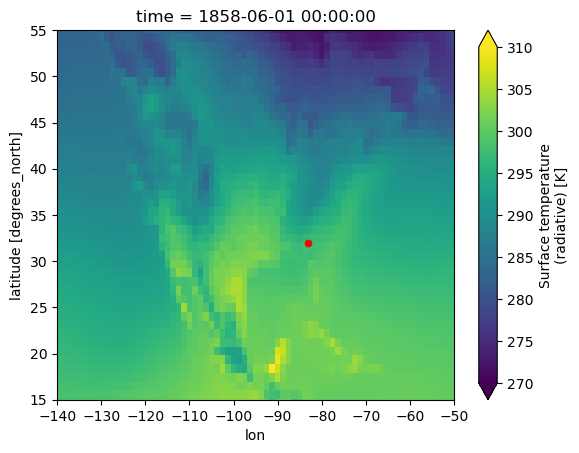

In [51]:
dsatm["TS"].isel(time=100).plot(xlim=[-140, -50], ylim=[15, 55], vmin=270, vmax=310)
plt.scatter(slon, slat, s=20, c="red")

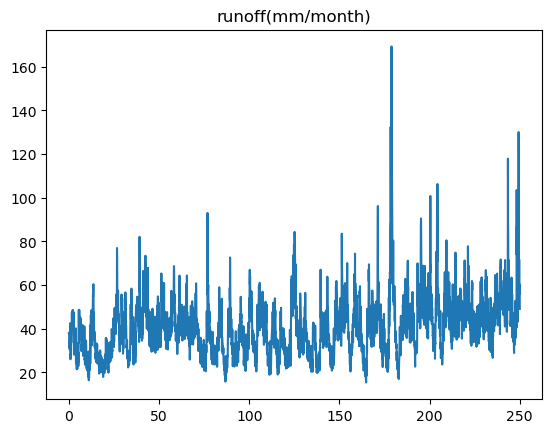

In [52]:
# --- quick sanity check plots
plotfirstXyears = 300

dfx1 = df1[df1.iloc[:, 0] < plotfirstXyears]
plt.plot(dfx1.iloc[:, 0], dfx1.iloc[:, 1])
plt.title(dfx1.columns[1]);

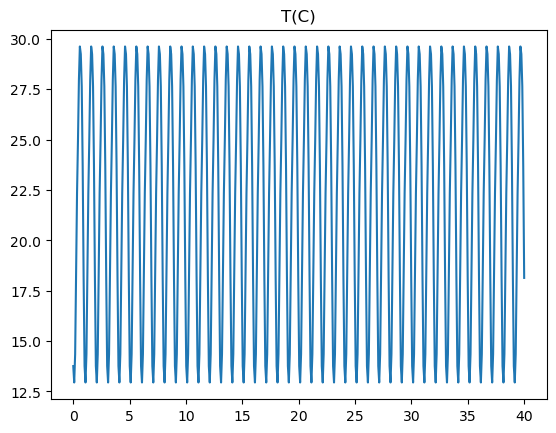

In [80]:
dfx2 = df2[df2.iloc[:, 0] < plotfirstXyears]
plt.plot(dfx2.iloc[:, 0], dfx2.iloc[:, 1])
plt.title(dfx2.columns[1]);

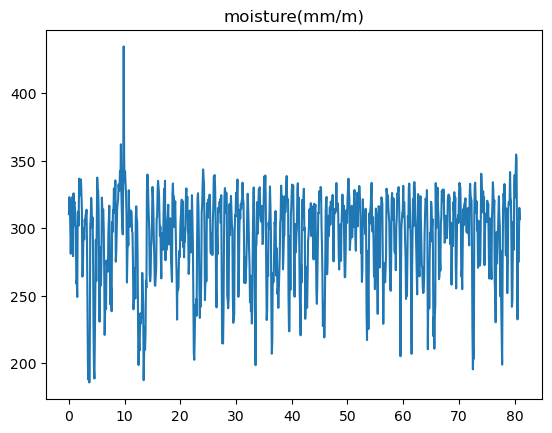

In [70]:
dfx3 = df3[df3.iloc[:, 0] < plotfirstXyears]
plt.plot(dfx3.iloc[:, 0], dfx3.iloc[:, 1])
plt.title(dfx3.columns[1]);

In [ ]:
# ---